In [ ]:
# Title
> Awesome summary
- name: "Tweet Sentiment Extraction_DISTILBERT"
- toc: true
- branch: master
- badges: true
- comments: true
- author: Hamel Husain & Jeremy Howard
- categories: [fastpages, jupyter]

**WELCOME ALL In this Notebook I use DistillBERT-Squad model**                                           

* Question----> the sentiment given in the dataset(postive/negative/neutral)
* Context-----> the text/tweet given in the dataset
* Answer---->the selected_text column in the training datset, and also we need the starting index of the answer(selected_text) in the text(tweet) 

This all should be in a json format which is required by distilBERT to train


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/config.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/vocab.txt
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/pytorch_model.bin
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/special_tokens_map.json
/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/tokenizer_config.json
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/simple-transformers-pypi/simpletransformers-0.22.1-py3-none-any.whl
/kaggle/input/simple-transformers-pypi/seqeval-0.0.12-py3-none-any.whl


In [2]:
train_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
import torch
#!pip install transformers
from transformers import BertForQuestionAnswering

#model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

question_p="positive sentence? "
question_n="negative sentence?"
question_neu="neutral sentence? " 

HERE i just change the terms positive,negative,neutral into questions in the train data

In [3]:
def make_question(x):
    if x=="positive":
        return question_p
    elif x=="negative":
        return question_n
    else:
        return question_neu
    
train_df["sentiment"]=train_df["sentiment"].apply(make_question)
train_df["sentiment"]

0         neutral sentence? 
1         negative sentence?
2         negative sentence?
3         negative sentence?
4         negative sentence?
                ...         
27476     negative sentence?
27477     negative sentence?
27478    positive sentence? 
27479    positive sentence? 
27480     neutral sentence? 
Name: sentiment, Length: 27481, dtype: object

In [4]:
train_df=train_df.dropna()

HERE I find the indices (start) of the selected_text from Text column and create a new column called answer_index

In [5]:
def answer_index(x):
    return x["text"].find(str(x["selected_text"]))
train_df["answer_index"]=train_df.apply(answer_index,axis=1)

In [6]:
train_df.head()


textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text           sentiment  answer_index  
0  I`d have responded, if I were going  neutral sentence?              1  
1                             Sooo SAD  negative sentence?             1  
2                          bullying me  negative sentence?            11  
3                       leave me alone  negative sentence?            17  
4                        Sons of ****,  negative sentence?             1

This big function below will make the training data suitable in the form of 
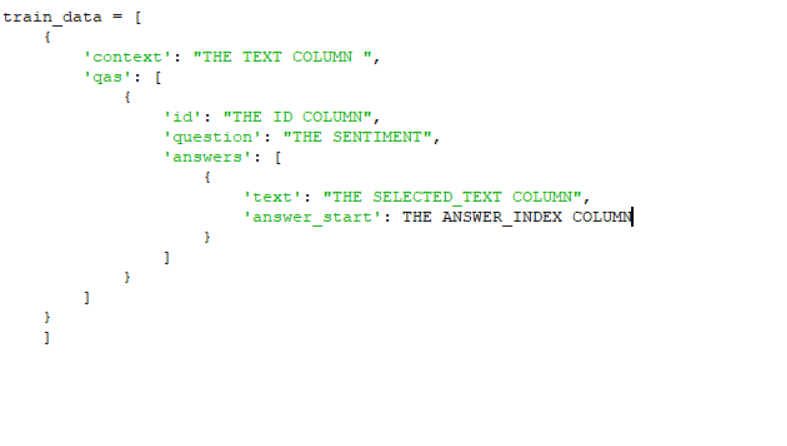

In [7]:
train_data=[]
def make_train_data(df):
    
    
    for ind in df.index:
        main_d=dict()
        context=df.loc[ind,"text"].lower()
        main_d["context"]=context
        qas=[]
        inside_qas={}
        inside_qas["id"]=df.loc[ind,"textID"]
        inside_qas["question"]=df.loc[ind,"sentiment"]
        inside_answer=[{"text":df.loc[ind,"selected_text"].lower(),"answer_start": int(df.loc[ind,"answer_index"])}]
        inside_qas["answers"]=inside_answer
        inside_qas["is_impossible"]=False
        qas.append(inside_qas)
        main_d["qas"]=qas
        train_data.append(main_d)
    return train_data
        
    
    
    
    
    
    
    
    


In [8]:

train_data=make_train_data(train_df)

In [9]:
train_df

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text            sentiment  \
0                    I`d have responded, if I were going   neutral sentence?    
1                                               Sooo SAD   negative sentence?   
2                                            bullying me   negative sentence?   
3                                         leave me alone   negative sentence?   
4                                          Sons of ****,   negative sentence?   
...                                                  ...                  ...   
27476                                             d lost   negative sentence?   
27477                                      , don`t force   negative sentence?   
27478                          Yay good for both of you.  positive sentence?    
27479                         But it was worth it  ****.  positive sentence?    
27480  All this flirting going on - The ATG smiles. Y...   neutral sentence?    

       answer_index  
0                 1  
1                 1  
2                11  
3                17  
4                 1  
...             ...  
27476            43  
27477            69  
27478             1  
27479             1  
27480             3  

[27480 rows x 5 columns]

HERE we convert it into json format and we shall be ready for the training

In [10]:
import json
#train_data_json=json.dumps(train_data)
with open('/kaggle/working/train.json', 'w') as outfile:
    json.dump(train_data, outfile)


    **Here I would like to thank Mr Jonathan Besomi https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack for the inspiration of using distilbert and that too without internet he as explained very nicely please do upvote it :D **

In [11]:
# !pip install '/kaggle/input/simple-transformers-pypi/seqeval-0.0.12-py3-none-any.whl' -q
# !pip install '/kaggle/input/simple-transformers-pypi/simpletransformers-0.22.1-py3-none-any.whl' -q


from simpletransformers.question_answering import QuestionAnsweringModel
MODEL_PATH = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/'

model=QuestionAnsweringModel("distilbert",MODEL_PATH,
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 2,
                                     'max_seq_length': 128,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=True)


In [12]:
model.train_model('/kaggle/working/train.json')

100%|██████████| 27480/27480 [00:51<00:00, 529.76it/s]


Running loss: 3.597266

/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 1.025785


Running loss: 1.473535



WE USE THE SAME FUNCTION FOR TRANSFORMING TRAINING DATA EXCEPT COMMENT SOME PARTS AS BELOW

In [13]:
test_data=[]

def make_test_data(df):
    
    
    for ind in df.index:
        main_d=dict()
        context=df.loc[ind,"text"].lower()
        main_d["context"]=context
        qas=[]
        inside_qas={}
        inside_qas["id"]=df.loc[ind,"textID"]
        inside_qas["question"]=df.loc[ind,"sentiment"]
        #inside_answer=[{"text":df.loc[ind,"selected_text"].lower(),"answer_start": int(df.loc[ind,"answer_index"])}]
        #inside_qas["answers"]=inside_answer
        inside_qas["is_impossible"]=False
        qas.append(inside_qas)
        main_d["qas"]=qas
        test_data.append(main_d)
    return test_data
        

In [14]:
test_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
test_df["sentiment"]=test_df["sentiment"].apply(make_question)

test_data=make_test_data(test_df)

test_data_json=json.dumps(test_data)
with open('/kaggle/working/test.json', 'w') as outfile:
    json.dump(test_data, outfile)

BADA_BING_BADA_BORE WE PREDICT AND HOPE FOR A GOOD SCORE :D

In [15]:
predictions=model.predict(test_data)

100%|██████████| 3534/3534 [00:05<00:00, 609.57it/s]


In [16]:
predictions_df = pd.DataFrame.from_dict(predictions)
sub_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
sub_df['selected_text'] = predictions_df['answer']

sub_df.to_csv('submission.csv', index=False)